In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('amazon_reviews.csv', encoding='latin-1')

In [4]:
df.shape

(4915, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


In [6]:
# Drop the row with the missing reviewText
df.dropna(subset=['reviewText'], inplace=True)

In [10]:
# Define a text cleaning function
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt_tab')

def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

# Apply the cleaning and stopword removal
df['cleaned_text'] = df['reviewText'].apply(clean_text)
stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['cleaned_text'].apply(
    lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [12]:
# Use CountVectorizer to create a document-term matrix
# This is a key step for LDA
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_text'])

In [13]:
# Define the number of topics you want to find
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 5
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [14]:
# Display the topics
feature_names = vectorizer.get_feature_names_out()
for index, topic in enumerate(lda_model.components_):
    print(f"Topic #{index+1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[-10:]]))
    print("\n")

Topic #1:
use gb files samsung galaxy format memory sd phone card


Topic #2:
fast gopro cards use micro works great sandisk sd card


Topic #3:
good card great memory product samsung use galaxy works tablet


Topic #4:
price galaxy memory space music card storage works phone great


Topic #5:
good bought amazon write read speed class cards sandisk card




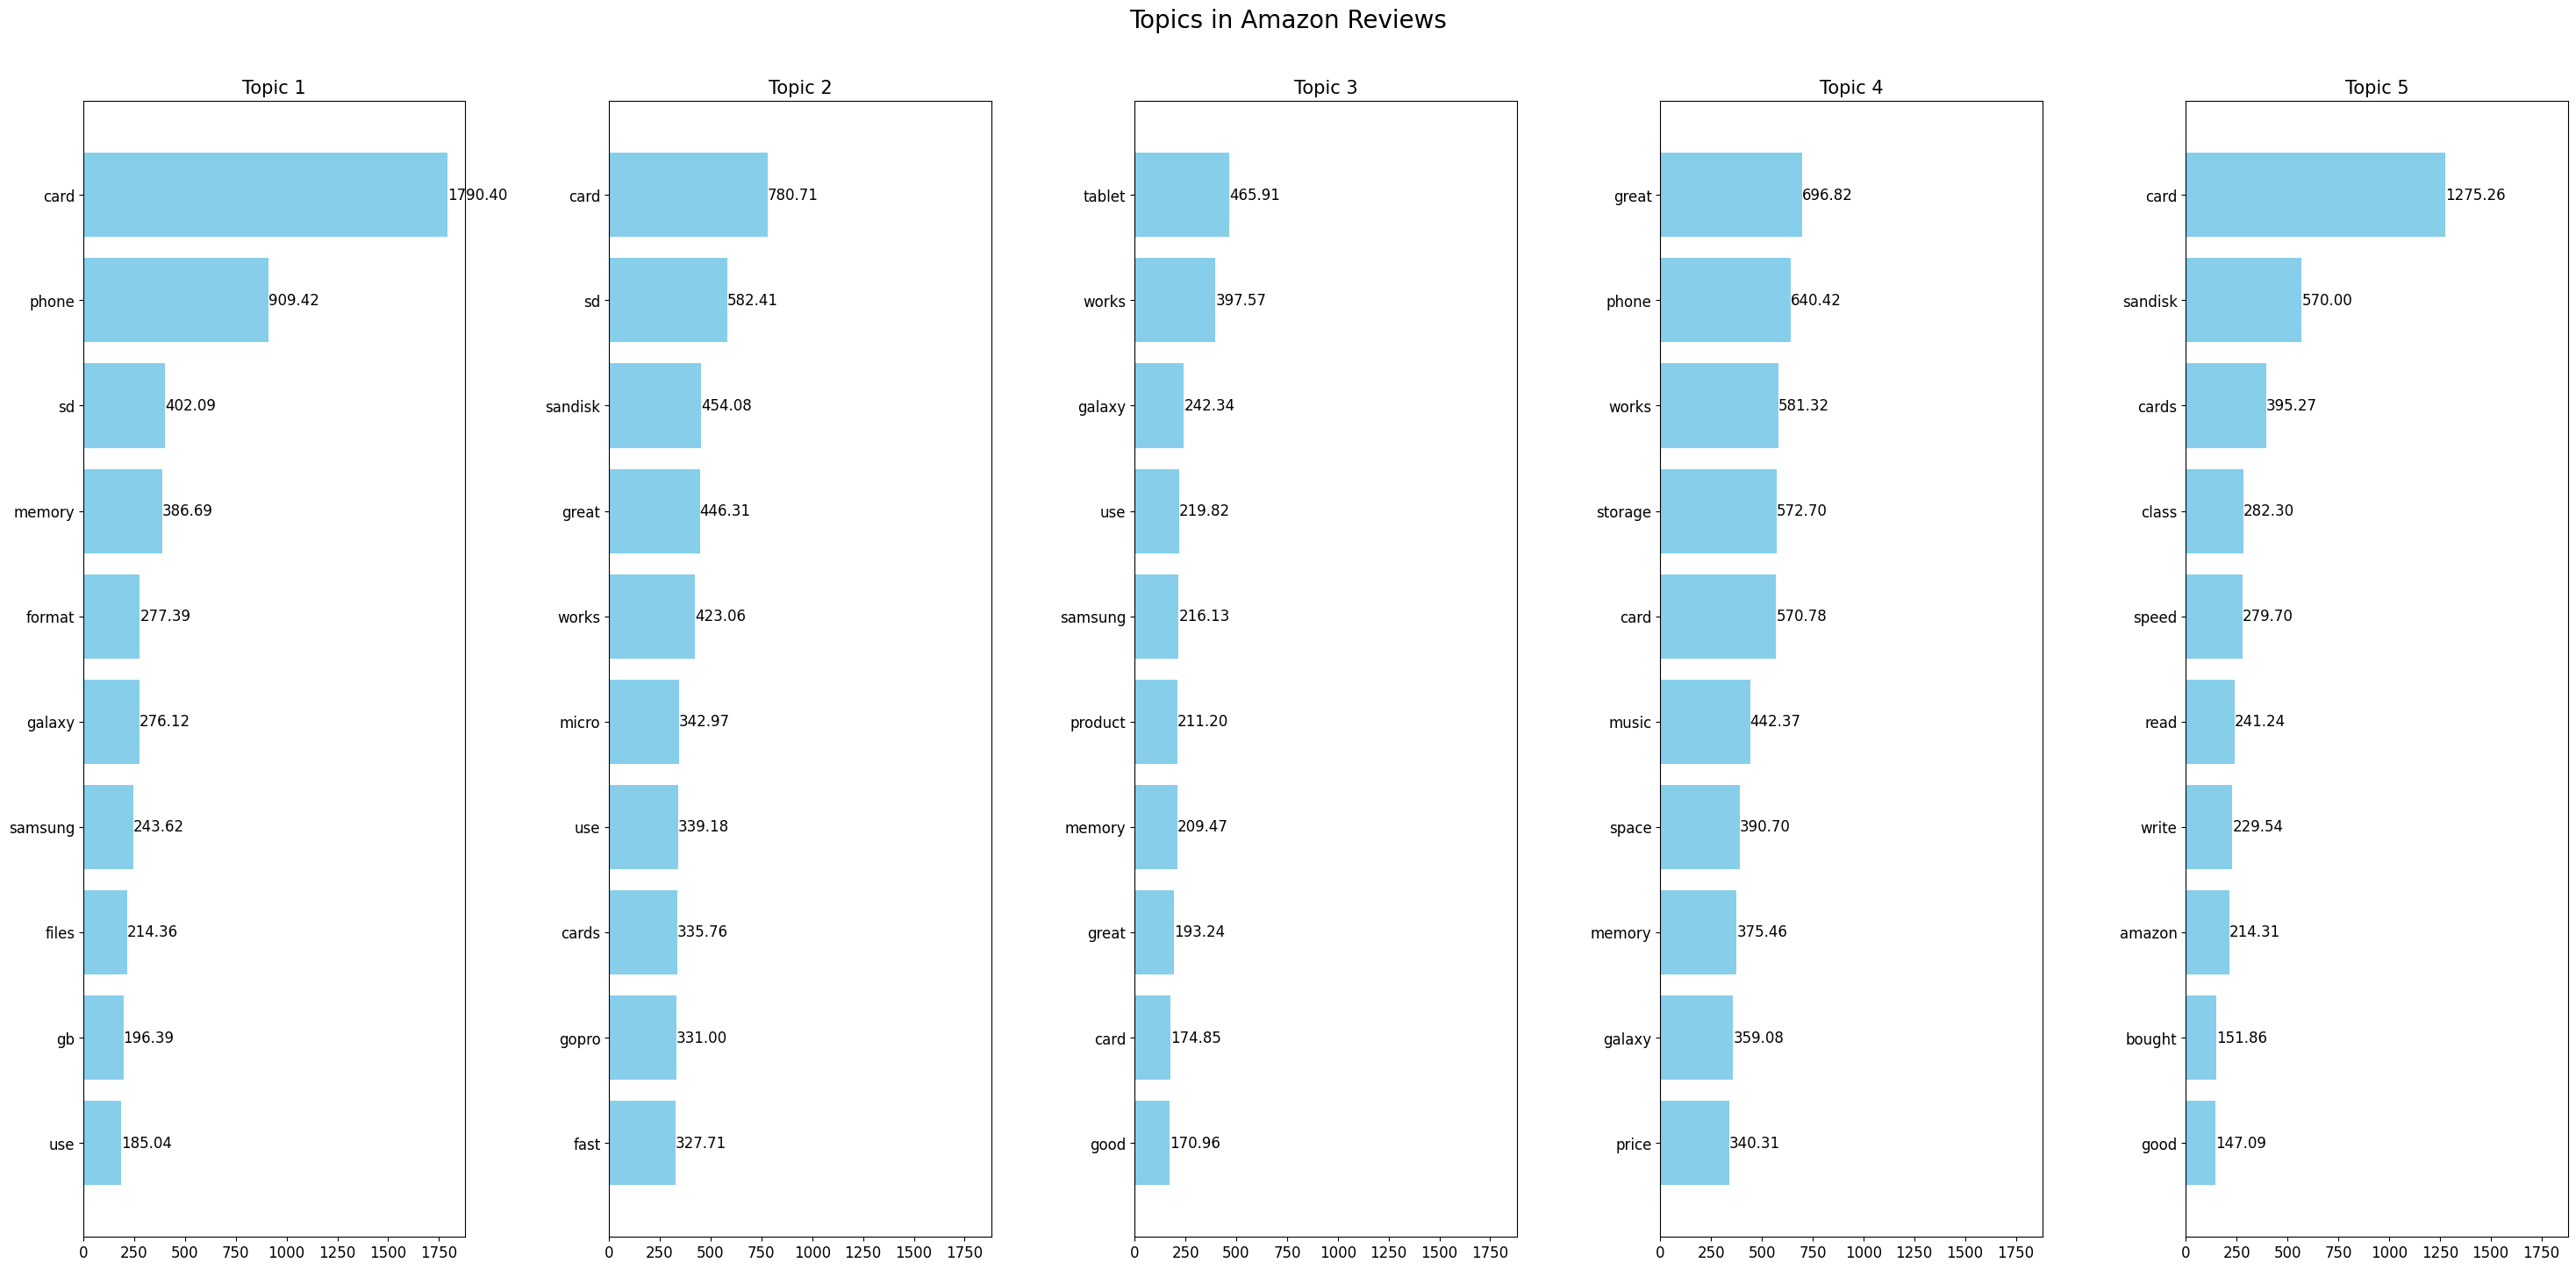

In [15]:
# Function to plot the top words for each topic
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, n_topics, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, color='skyblue')
        ax.set_title(f'Topic {topic_idx +1}', fontdict={'fontsize': 15})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i, v in enumerate(weights):
            ax.text(v + 0.05, i, f'{v:.2f}', color='black', va='center', fontsize=12)
    plt.suptitle(title, fontsize=20)
    plt.tight_layout(pad=3.0)
    plt.show()

# Visualize the topics
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda_model, feature_names, 10, 'Topics in Amazon Reviews')